<a href="https://colab.research.google.com/github/Ilia-Gershen/TYP-project/blob/main/DeepLearningModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning Model:


1.   Fuction Dataset for data separation into test and train
2.   Creation of the Model



## Importing libraries and data from google drive


In [4]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
# warnings.filterwarnings('ignore')

In [5]:
from google.colab import drive #connecting google drive with Database of the project
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Importing the csv made in data preprocessing stage
ETH = pd.read_csv("/content/drive/MyDrive/Database/ETH-preprocessed.csv")
#ETH.sort_values(by = 'Date', ascending = False, inplace = True) #sorting it so on the top are the most recent dates
ETH.head()

,Unnamed: 0,Date,Open,High,Low,Close,Adj Close,Volume
0,0,2017-11-19,347.401001,371.290985,344.739990,354.385986,354.385986,1.181530e+09
1,1,2017-11-20,354.093994,372.136993,353.289001,366.730011,366.730011,8.070270e+08
2,2,2017-11-21,367.442993,372.470001,350.692993,360.401001,360.401001,9.499120e+08
3,3,2017-11-22,360.312012,381.420013,360.147003,380.652008,380.652008,8.008190e+08
4,4,2017-11-23,381.438995,425.548004,376.088013,410.165985,410.165985,1.845680e+09


## Data Processing

In [7]:
def Dataset(Data, Date): #function for creation of traning and testing datasets for the models

  #Data for Training 
  Train_Data = Data['Close'][Data['Date'] < Date].to_numpy() #taking data befor the given date
  TrainingData = []
  TrainingDataX = []
  TrainingDataY = []

  for i in range(0, len(Train_Data), 7): #putting in close values data in form of weeks aka 7 days
    try:
      TrainingData.append(Train_Data[i:i+7]) #array of arrays of 7 close prices
    except:
      pass

  if len(TrainingData[-1]) < 7: #If last week is less then 7 days we remove last week
    TrainingData.pop(-1)

  TrainingDataX = TrainingData[0 : -1] # converting to np array
  TrainingDataX = np.array(TrainingDataX)
  TrainingDataX = TrainingDataX.reshape((-1, 7, 1)) #split into groups of 7 

  TrainingDataY = TrainingData[1:len(TrainingData)] # converting to np array
  TrainingDataY = np.array(TrainingDataY)
  TrainingDataY = TrainingDataY.reshape((-1, 7, 1)) # split into groups of 7 and keep the order

  #Data for Testing
  Test_Data = Data['Close'][Data['Date'] >= Date].to_numpy() #taking data from given date to latest date
  TestData = []
  TestDataX = []
  TestDataY = []

  for i in range(0, len(Test_Data), 7):
    try:
      TestData.append(Test_Data[i : i + 7])
    except:
      pass

  if len(TestData[-1]) < 7:
    TestData.pop(-1)

  TestDataX = TestData[0 : -1]
  TestDataX = np.array(TestDataX)
  TestDataX = TestDataX.reshape((-1, 7, 1))

  TestDataY = TestData[1 : len(TestData)]
  TestDataY = np.array(TestDataY)
  TestDataY = TestDataY.reshape((-1, 7, 1))
 
  return TrainingDataX, TrainingDataY, TestDataX, TestDataY


## Model creation and testing

### LSTM - GRU model


In [8]:
def Model():

  model = tf.keras.models.Sequential([ #input shape first number is number of days we will predict and second one is number of purumenters use for prediction
      tf.keras.layers.LSTM(200, input_shape = (7,1), activation = tf.nn.leaky_relu, return_sequences = True),
      tf.keras.layers.GRU(200, activation = tf.nn.leaky_relu), #or make in 150 if it will not work
      tf.keras.layers.Dense(100, activation = tf.nn.leaky_relu),
      tf.keras.layers.Dense(50, activation = tf.nn.leaky_relu),
      tf.keras.layers.Dense(7, activation = tf.nn.leaky_relu)
  ])

  return model

In [9]:
model = Model()

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 200)            161600    
                                                                 
 gru (GRU)                   (None, 200)               241200    
                                                                 
 dense (Dense)               (None, 100)               20100     
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dense_2 (Dense)             (None, 7)                 357       
                                                                 
Total params: 428,307
Trainable params: 428,307
Non-trainable params: 0
_________________________________________________________________


#### Learning Rate

In [46]:
def scheduler(epoch):
  #if epoch <= 150:
  #  lrate = (10 ** -5) * (epoch / 150)
  #elif epoch <= 400:
  #  initialLrate = (10 ** -5)
  #  k = 0.01
  #  lrate = initialLrate * math.exp(-k * (epoch - 150))
  #else:
  #  lrate = (10 ** -6)
  #lrate = 10 ** -6
  #if epoch < 300:
  #  lrate = 0.06 * (10 ** -5)
  #elif epoch <600:
  #  lrate = 0.66 * (10 ** -5)
  #else:
  #  lrate = 1.1 * (10 ** -5)
  if epoch <= 100:
    lrate = epoch * (10 ** -6)
  else:
    lrate = 0.00001
  return lrate

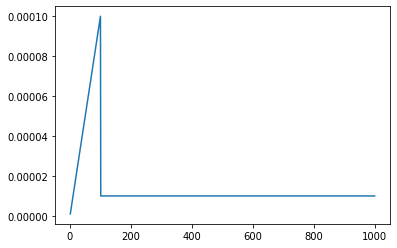

In [47]:
epoch = [i for i in range(1, 1001)]
lrate = [scheduler(i) for i in range(1, 1001)]
plt.plot(epoch, lrate)

In [48]:
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [49]:
ETH.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1827 entries, 0 to 1826
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Unnamed: 0  1827 non-null   int64         
 1   Date        1827 non-null   datetime64[ns]
 2   Open        1827 non-null   float64       
 3   High        1827 non-null   float64       
 4   Low         1827 non-null   float64       
 5   Close       1827 non-null   float64       
 6   Adj Close   1827 non-null   float64       
 7   Volume      1827 non-null   float64       
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 114.3 KB


In [50]:
ETH["Date"] = pd.to_datetime(ETH["Date"])

#### Split Data into Training and Testing sets


*   Training Period: 2017-11-19 to 2021-11-19
*   Testing Period: 2021-11-20 to 2022-11-19



In [51]:
ETH_Train_X, ETH_Train_Y, ETH_Test_X, ETH_Test_Y = Dataset(ETH, '2021-11-20')

#### Model Fitting

In [52]:
ETH_Model = Model()

In [53]:
ETH_Model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mse', metrics = tf.keras.metrics.RootMeanSquaredError())

In [54]:
ETH_hist = ETH_Model.fit(ETH_Train_X, ETH_Train_Y, epochs = 200, validation_data = (ETH_Test_X, ETH_Test_Y), callbacks = [callback])

Epoch 1/200
7/7 [==============================] - 3s 112ms/step - loss: 1751429.3750 - root_mean_squared_error: 1323.4158 - val_loss: 6045353.0000 - val_root_mean_squared_error: 2458.7297 - lr: 0.0000e+00
Epoch 2/200
7/7 [==============================] - 0s 49ms/step - loss: 1751237.6250 - root_mean_squared_error: 1323.3433 - val_loss: 6044226.0000 - val_root_mean_squared_error: 2458.5007 - lr: 1.0000e-06
Epoch 3/200
7/7 [==============================] - 0s 49ms/step - loss: 1750647.3750 - root_mean_squared_error: 1323.1204 - val_loss: 6041390.0000 - val_root_mean_squared_error: 2457.9238 - lr: 2.0000e-06
Epoch 4/200
7/7 [==============================] - 0s 46ms/step - loss: 1749898.6250 - root_mean_squared_error: 1322.8374 - val_loss: 6037324.0000 - val_root_mean_squared_error: 2457.0967 - lr: 3.0000e-06
Epoch 5/200
7/7 [==============================] - 0s 50ms/step - loss: 1748739.5000 - root_mean_squared_error: 1322.3992 - val_loss: 6032153.0000 - val_root_mean_squared_error: 2

In [55]:
historyDict = ETH_hist.history

loss = historyDict["loss"]
root_mean_squared_error = historyDict["root_mean_squared_error"]
valLoss = historyDict["val_loss"]
val_root_mean_squared_error = historyDict["val_root_mean_squared_error"]

epochs = range(1, len(loss) + 1)

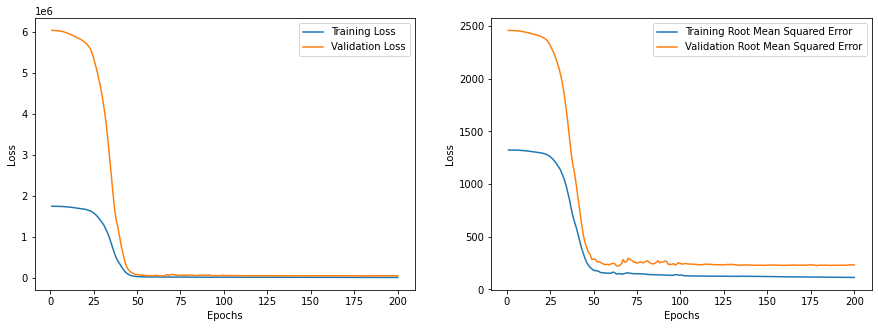

In [56]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(epochs, loss, label = 'Training Loss')
ax1.plot(epochs, valLoss, label = 'Validation Loss')
ax1.set(xlabel = "Epochs", ylabel = "Loss")
ax1.legend()

ax2.plot(epochs, root_mean_squared_error, label = "Training Root Mean Squared Error")
ax2.plot(epochs, val_root_mean_squared_error, label = "Validation Root Mean Squared Error")
ax2.set(xlabel = "Epochs", ylabel = "Loss")
ax2.legend()

plt.show()

#### Predicting the closing price for ETH for a week

In [57]:
ETH_prediction = ETH_Model.predict(ETH_Test_X)

2/2 [==============================] - 0s 15ms/step


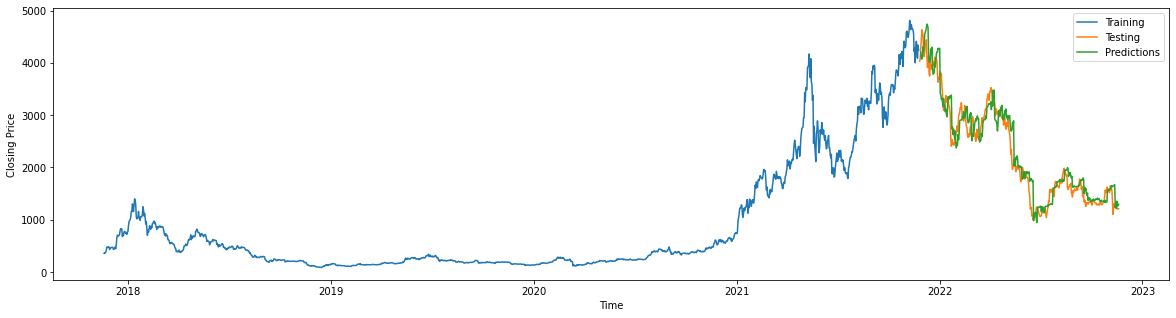

In [58]:
plt.figure(figsize = (20, 5))

plt.plot(ETH['Date'][ETH['Date'] < '2021-11-25'], ETH['Close'][ETH['Date'] < '2021-11-25'], label = 'Training')
plt.plot(ETH['Date'][ETH['Date'] >= '2021-11-26'], ETH['Close'][ETH['Date'] >= '2021-11-26'], label = 'Testing')
plt.plot(ETH['Date'][ETH['Date'] >= '2021-11-28'], ETH_prediction.reshape(-1), label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')

In [59]:
rmse = math.sqrt(mean_squared_error(ETH_Test_Y.reshape(-1,7), ETH_prediction))
mape = np.mean(np.abs(ETH_Test_Y.reshape(-1,7) - ETH_prediction )/np.abs(ETH_Test_Y.reshape(-1,7))) * 100
print(f'RMSE: {rmse}') #lower is better
print(f'MAPE: {mape}') #mape should be as close to 0 as possible, but mape within 10% is ok

RMSE: 232.07148969061572
MAPE: 8.13661453907012


### GRU - LSTM model